In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time

#Visualization
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

#Data preparation
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Models
from sklearn.linear_model import LinearRegression                             
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

#Metrics
from sklearn.metrics import (explained_variance_score, max_error, 
                             mean_absolute_error, mean_squared_error, 
                             median_absolute_error, r2_score)

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from collections import Counter

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Import data

In [8]:
# Base de Treino
df_train = pd.read_csv("train.csv")

# Base de Teste
df_test = pd.read_csv("test.csv")
df_test_n = pd.read_csv("test.csv")

In [9]:
df_train.shape, df_train.NU_INSCRICAO.nunique(), df_train.NU_ANO.value_counts()

((13730, 167), 13730, 2016    13730
 Name: NU_ANO, dtype: int64)

In [10]:
df_test.shape

(4576, 47)

In [11]:
# Temos apenas 47 features na base de teste, portanto é interessante treinar apenas com features em comum

x_features = set.intersection(set(df_test.columns.to_list()), set(df_train.columns.to_list()))

target = df_train.NU_NOTA_MT
df_train = df_train[x_features] # 13730, 48
df_train['istrain'] = 1
df_test = df_test[x_features] # 4576, 47

df_full = pd.concat([df_train,df_test], axis = 0, sort = False).reset_index(drop = True)
df_full.istrain.fillna(0,inplace=True)

df_num = df_full.select_dtypes(exclude='object') # 18306, 33
df_str = df_full.select_dtypes(include='object') # 18306, 15

In [12]:
df_full.head()

,TP_COR_RACA,TP_ANO_CONCLUIU,IN_BAIXA_VISAO,NU_NOTA_LC,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,Q025,NU_NOTA_CH,NU_IDADE,IN_SURDEZ,...,TP_STATUS_REDACAO,TP_ST_CONCLUSAO,TP_SEXO,CO_PROVA_CN,TP_PRESENCA_CH,NU_NOTA_COMP4,TP_ENSINO,CO_UF_RESIDENCIA,Q047,istrain
0,1,4,0,581.2,NaN,436.3,A,495.4,24,0,...,1.0,1,M,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,1,80.0,NaN,43,A,1.0
1,3,0,0,599.0,2.0,474.5,A,544.1,17,0,...,1.0,2,F,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,1,120.0,1.0,23,A,1.0
2,3,0,0,NaN,NaN,NaN,A,NaN,21,0,...,NaN,3,F,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,NaN,NaN,23,A,1.0
3,0,9,0,NaN,NaN,NaN,B,NaN,25,0,...,NaN,1,F,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,NaN,NaN,33,D,1.0
4,2,4,0,NaN,NaN,NaN,A,NaN,28,0,...,NaN,1,M,2d22ac1d42e6187f09ee6c578df187a760123ccf,0,NaN,NaN,13,A,1.0


In [13]:
print('Int64:')
print(df_full.select_dtypes(include='Int64').columns.values)
print('\nFloat64:')
print(df_full.select_dtypes(include='Float64').columns.values)
print('\nStrings:')
print(df_full.select_dtypes(include='object').columns.values)

Int64:
['TP_COR_RACA' 'TP_ANO_CONCLUIU' 'IN_BAIXA_VISAO' 'NU_IDADE' 'IN_SURDEZ'
 'IN_CEGUEIRA' 'TP_NACIONALIDADE' 'IN_DISLEXIA' 'IN_IDOSO'
 'TP_PRESENCA_LC' 'TP_ESCOLA' 'IN_GESTANTE' 'TP_LINGUA' 'IN_TREINEIRO'
 'IN_DISCALCULIA' 'IN_SABATISTA' 'TP_PRESENCA_CN' 'TP_ST_CONCLUSAO'
 'TP_PRESENCA_CH' 'CO_UF_RESIDENCIA']

Float64:
['NU_NOTA_LC' 'TP_DEPENDENCIA_ADM_ESC' 'NU_NOTA_CN' 'NU_NOTA_CH'
 'NU_NOTA_COMP3' 'NU_NOTA_REDACAO' 'NU_NOTA_COMP2' 'NU_NOTA_COMP1'
 'NU_NOTA_COMP5' 'TP_STATUS_REDACAO' 'NU_NOTA_COMP4' 'TP_ENSINO' 'istrain']

Strings:
['Q025' 'Q006' 'Q002' 'SG_UF_RESIDENCIA' 'CO_PROVA_MT' 'Q026' 'Q027'
 'NU_INSCRICAO' 'Q001' 'CO_PROVA_LC' 'CO_PROVA_CH' 'Q024' 'TP_SEXO'
 'CO_PROVA_CN' 'Q047']


### Data Cleaning

In [14]:
#Returns null values (%)
def get_nans(df):
    nan_dic = {}
    for col in df.columns:
        if df[col].isnull().any() == True:
            nan_dic[col] = df[col].isnull().sum()
    return pd.DataFrame({
        'Feature': list(nan_dic.keys()),
        'Nulls': list(nan_dic.values()),
        'Percent': np.round((np.array(list(nan_dic.values())) / df.shape[0])*100, decimals = 1)
    }).sort_values('Nulls',ascending = False)

#Returns 0 values (%)
def get_zeros(df):
    zero_dic = {}
    for col in df.columns:
        if (df[col] == 0).sum() > 0:
            zero_dic[col] = (df[col] == 0).sum()
    return pd.DataFrame({'Feature': list(zero_dic.keys()),
                        'Zeros': list(zero_dic.values()),
                        'Percent': np.round((np.array(list(zero_dic.values())) / df.shape[0])*100, decimals = 1)
    }).sort_values('Zeros',ascending = False)

In [15]:
#Situação das variáveis numéricas

print('Sumário dos nulos:')
print(get_nans(df_num))
print('')
print('Sumário dos zeros:')
print(get_zeros(df_num))

Sumário dos nulos:
                   Feature  Nulls  Percent
1   TP_DEPENDENCIA_ADM_ESC  12544     68.5
11               TP_ENSINO  12544     68.5
0               NU_NOTA_LC   4796     26.2
4            NU_NOTA_COMP3   4796     26.2
5          NU_NOTA_REDACAO   4796     26.2
6            NU_NOTA_COMP2   4796     26.2
7            NU_NOTA_COMP1   4796     26.2
8            NU_NOTA_COMP5   4796     26.2
9        TP_STATUS_REDACAO   4796     26.2
10           NU_NOTA_COMP4   4796     26.2
2               NU_NOTA_CN   4523     24.7
3               NU_NOTA_CH   4523     24.7

Sumário dos zeros:
             Feature  Zeros  Percent
7        IN_CEGUEIRA  18306    100.0
9        IN_DISLEXIA  18305    100.0
18    IN_DISCALCULIA  18305    100.0
10          IN_IDOSO  18304    100.0
6          IN_SURDEZ  18300    100.0
14       IN_GESTANTE  18291     99.9
2     IN_BAIXA_VISAO  18285     99.9
20      IN_SABATISTA  18126     99.0
17      IN_TREINEIRO  15940     87.1
1    TP_ANO_CONCLUIU   9654     

In [16]:
#Situação das variáveis categóricas

print('Sumário dos nulos:')
print(get_nans(df_str))

Sumário dos nulos:
  Feature  Nulls  Percent
0    Q027   9861     53.9


In [17]:
#Cleaner

class Cleaner:
    
    from sklearn.preprocessing import MinMaxScaler
    
    def __init__(self, dataframe, bin_list = [], scaler_list = [], ordinal_list = [], dummy_list = [], clean_nan = False):    
        self.dataframe = dataframe
        self.bin_list = bin_list
        self.scaler_list = scaler_list
        self.ordinal_list = ordinal_list
        self.dummy_list = dummy_list
        self.clean_nan = clean_nan
    
    def transform(self):    
        dataframe = self.dataframe
        dataframe_cols = dataframe.columns.values.tolist()

        #Binariza
        if bool(self.bin_list):
            for col in self.bin_list:
                dataframe[col] = [0 if x == 0 else 1 for x in dataframe[col]]

        #Escalona(MinMax)
        if bool(self.scaler_list):
            scaler = MinMaxScaler()
            dataframe.loc[:,self.scaler_list] = scaler.fit_transform(dataframe.loc[:,self.scaler_list])

        #Label Ordinal  
        if bool(self.ordinal_list):
            for col in self.ordinal_list:
                dataframe[col] = dataframe[col].map({'M':13, 'K':12, 'L':11, 'J':10, 'I':9, 'H':8, 'G':7,
                                                     'F':6, 'E':5, 'D':4, 'C':3, 'B':2, 'A':1, np.nan:0})


        if bool(self.dummy_list):
            dataframe = pd.get_dummies(dataframe, columns=self.dummy_list, drop_first=True)

        if self.clean_nan:
            for col in dataframe.select_dtypes(exclude='object').columns.tolist():
                dataframe[col].fillna(dataframe[col].median(), inplace = True)

      
        return dataframe

In [18]:
df_full.drop('NU_INSCRICAO', axis = 1, inplace = True)

In [19]:
#Variáveis que são ordinais
ordinal_list = ['Q001','Q006','Q047', 'Q025', 'Q026', 'Q002', 'Q024', 'Q027']

dummy_list = ['CO_PROVA_MT', 'CO_PROVA_LC', 'SG_UF_RESIDENCIA', 'TP_SEXO', 'CO_PROVA_CN',
               'CO_PROVA_CH']

#Instânciando cleaner
cleaner = Cleaner(df_full,
                  ordinal_list = ordinal_list,
                  dummy_list = dummy_list,
                  clean_nan = True)

print(f'Shape antes do dummify: {df_full.shape}')

#Aplicando transformações
df_full = cleaner.transform()

#Shape
print(f'Shape após o dummify: {df_full.shape}')

Shape antes do dummify: (18306, 47)
Shape após o dummify: (18306, 102)


### Exploratory Data Analysis

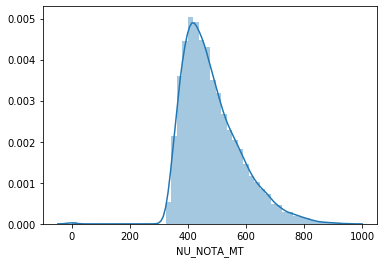

In [20]:
# Distribuição das notas de matemática (target)
sns.distplot(target[target.notnull()]);

### Scaling

In [21]:
def scaling(df):
    scaler = StandardScaler()
    for col in df.columns:

        if col == 'istrain':
            pass

        elif df[col].unique().tolist() != [0,1]:
            df[col] = scaler.fit_transform(df[[col]])
    return df

#Aplicando scaling
df_full = scaling(df_full)

In [22]:
df_full.head()

,TP_COR_RACA,TP_ANO_CONCLUIU,IN_BAIXA_VISAO,NU_NOTA_LC,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,Q025,NU_NOTA_CH,NU_IDADE,IN_SURDEZ,...,CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa,CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93,CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273,CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164,CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5,CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee,CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f
0,-1.173031,0.578611,0,1.092252,-0.199059,-0.543028,-1.154498,-0.544356,0.345755,0,...,0,0,0,0,0,2.037355,0,0,0,0
1,0.807554,-0.665390,0,1.394827,-0.199059,0.073516,-1.154498,0.218495,-0.654759,0,...,0,0,0,1,0,-0.490832,0,0,0,0
2,0.807554,-0.665390,0,0.048540,-0.199059,-0.170197,-1.154498,0.028957,-0.083037,0,...,0,1,0,0,0,-0.490832,0,0,0,0
3,-2.163323,2.133612,0,0.048540,-0.199059,-0.170197,0.866177,0.028957,0.488686,0,...,0,1,0,0,0,-0.490832,0,0,0,0
4,-0.182738,0.578611,0,0.048540,-0.199059,-0.170197,-1.154498,0.028957,0.917478,0,...,0,1,0,0,0,-0.490832,0,0,0,0


### Baseline model

In [23]:
#Separando
df_train = df_full.loc[df_full.istrain == 1]
df_test = df_full.loc[df_full.istrain == 0]

print(f'Train shape: {df_train.shape}')
print(f'Test shape: {df_test.shape}')
print(f'Target shape: {target.shape}')

Train shape: (13730, 102)
Test shape: (4576, 102)
Target shape: (13730,)


In [24]:
y = target.fillna(0)
X = df_train

In [37]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)


In [41]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

(0.9189634333638148, -4.18222874449117e+18)

**Um modelo baseline é importante para identificarmos o ponto de partida do modelo. Devemos aprimorar essa abordagem e comparar os futuros scores com este, realizado com pouco esforço de feature selection, feature engineering e tuning de hiperparâmetros.**

In [26]:
df_full.head()

,TP_COR_RACA,TP_ANO_CONCLUIU,IN_BAIXA_VISAO,NU_NOTA_LC,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,Q025,NU_NOTA_CH,NU_IDADE,IN_SURDEZ,...,CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa,CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93,CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273,CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164,CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5,CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee,CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f
0,-1.173031,0.578611,0,1.092252,-0.199059,-0.543028,-1.154498,-0.544356,0.345755,0,...,0,0,0,0,0,2.037355,0,0,0,0
1,0.807554,-0.665390,0,1.394827,-0.199059,0.073516,-1.154498,0.218495,-0.654759,0,...,0,0,0,1,0,-0.490832,0,0,0,0
2,0.807554,-0.665390,0,0.048540,-0.199059,-0.170197,-1.154498,0.028957,-0.083037,0,...,0,1,0,0,0,-0.490832,0,0,0,0
3,-2.163323,2.133612,0,0.048540,-0.199059,-0.170197,0.866177,0.028957,0.488686,0,...,0,1,0,0,0,-0.490832,0,0,0,0
4,-0.182738,0.578611,0,0.048540,-0.199059,-0.170197,-1.154498,0.028957,0.917478,0,...,0,1,0,0,0,-0.490832,0,0,0,0


**1 Submission: XGBOOST**

In [39]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
xgb.score(X_train, y_train), xgb.score(X_test, y_test)

(0.9680954193789263, 0.9687402616515276)

In [74]:
# Submit 1
y_sub1 = model.predict(df_test) # Score: 93.61

pd.DataFrame({'NU_INSCRICAO':df_test_n.NU_INSCRICAO,'NU_NOTA_MT':y_sub1}).to_csv("answer1.csv", index= False)

**2 Submission: PCA + XGBOOST**

In [47]:
from sklearn.decomposition import PCA

In [70]:
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [71]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train_pca, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
X_train_pca.shape, X_test_pca.shape

((9611, 40), (4119, 40))

In [75]:
xgb.score(X_train_pca, y_train), xgb.score(X_test_pca, y_test)

(0.9831360982077544, 0.9162569968189286)

In [79]:
# Submit 2
df_test_pca = pca.transform(df_test)
y_sub2 = xgb.predict(df_test_pca) # Score: 93.13

pd.DataFrame({'NU_INSCRICAO':df_test_n.NU_INSCRICAO,'NU_NOTA_MT':y_sub2}).to_csv("answer2.csv", index= False)

**3 Submission: AutoML**

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)